In [ ]:
def extract_objects(image):
    # Use Detectron2
    return ["man", "bench", "book"]

def extract_actions(image):
    # Use MMAction2 or LLaVA
    return ["reading"]

def extract_attributes(image):
    # Use CNN or heuristics
    return {"man": "blue shirt"}

In [ ]:
import torch
import torchvision
import os

print("🧠 PyTorch version:", torch.__version__)
print("🎨 Torchvision version:", torchvision.__version__)
print("⚡ CUDA available:", torch.cuda.is_available())
print("⚡ CUDA version:", torch.version.cuda)


🧠 PyTorch version: 2.6.0+cu124
🎨 Torchvision version: 0.21.0+cu124
⚡ CUDA available: True
⚡ CUDA version: 12.4


## TIFA Section

In [1]:
import torch

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

PyTorch Version: 2.6.0+cu124
CUDA Available: True
CUDA Version: 12.4
GPU Name: Tesla T4


In [8]:
!pip uninstall -y bitsandbytes
!pip install -U bitsandbytes


  Using cached bitsandbytes-0.45.5-py3-none-manylinux_2_24_x86_64.whl.metadata (5.0 kB)
Using cached bitsandbytes-0.45.5-py3-none-manylinux_2_24_x86_64.whl (76.1 MB)


In [6]:
!pip list

Package                               Version
------------------------------------- ------------------
absl-py                               1.4.0
accelerate                            1.5.2
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.23
albumentations                        2.0.5
ale-py                                0.10.2
altair                                5.5.0
annotated-types                       0.7.0
anyio                                 4.9.0
argon2-cffi                           23.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.1
arviz                                 0.21.0
astropy                               7.0.1
astropy-iers-data                     0.2025.4.7.0.35.30
astunparse                            1.6.3
atpublic                              5.1

In [1]:
import torch
import transformers
import accelerate
import bitsandbytes
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

In [2]:
import torch
import bitsandbytes as bnb

print("CUDA Available:", torch.cuda.is_available())
print("bnb version:", bnb.__version__)


CUDA Available: True
bnb version: 0.45.5


In [3]:
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

model_name = "tifa-benchmark/llama2_tifa_question_generation"

# Load model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quant_config,
    device_map="auto"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

In [4]:

# # Define model name
# model_name = "tifa-benchmark/llama2_tifa_question_generation"

# # Load model with 4-bit quantization
# model = AutoModelForCausalLM.from_pretrained(
#     model_name,
#     load_in_4bit=True,  # Enables 4-bit mode
#     device_map="auto"   # Automatically selects best device
# )

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Function to format prompt
def create_qg_prompt(caption):
    INTRO_BLURB = "Given an image description, generate one or two multiple-choice questions that verifies if the image description is correct.\nClassify each concept into a type (object, human, animal, food, activity, attribute, counting, color, material, spatial, location, shape, other), and then generate a question for each type.\n"
    formatted_prompt = f"<s>[INST] <<SYS>>\n{INTRO_BLURB}\n<</SYS>>\n\n"
    formatted_prompt += f"Description: {caption} [/INST] Entities:"
    return formatted_prompt

# Define caption
test_caption = "Two horses eating grass in a field"

# Create prompt
prompt = create_qg_prompt(test_caption)

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate text
with torch.no_grad():
    output_ids = model.generate(
        **inputs,
        do_sample=False,
        num_beams=3,  # Reduce from 5 to 3 for faster processing
        max_length=256  # Reduce max length to speed up computation
    )

# Decode and format output
output = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(output)


tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

[INST] <<SYS>>
Given an image description, generate one or two multiple-choice questions that verifies if the image description is correct.
Classify each concept into a type (object, human, animal, food, activity, attribute, counting, color, material, spatial, location, shape, other), and then generate a question for each type.

<</SYS>>

Description: Two horses eating grass in a field [/INST] Entities: horses, grass, field
Activites: eating
Colors: 
Counting: two
Other attributes: 
About horses (animal):
Q: are there horses?
Choices: yes, no
A: yes
About horses (animal):
Q: what animals are in the picture?
Choices: horses, cows, sheep, goats
A: horses
About grass (object):
Q: is there grass?
Choices: yes, no
A: yes
About grass (object):
Q: what is the horses eating?
Choices: grass, hay, leaves, twigs
A: grass
About field (location):
Q: is this


In [5]:
import re
def extract_questions(text):
    """Extracts questions from TIFA's formatted output."""
    return re.findall(r'Q:\s(.+?)\nChoices:', text)

def extract_expected_answers(text):
    """Extracts expected answers from TIFA's output."""
    return re.findall(r'A:\s(.+?)\n', text)

# Get questions and expected answers
questions = extract_questions(output)
expected_answers = extract_expected_answers(output)

print("\nExtracted Questions:", questions)
print("Expected Answers:", expected_answers)


Extracted Questions: ['are there horses?', 'what animals are in the picture?', 'is there grass?', 'what is the horses eating?']
Expected Answers: ['yes', 'horses', 'yes', 'grass']


### Adding BLIP

In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch
from PIL import Image

# Load BLIP model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

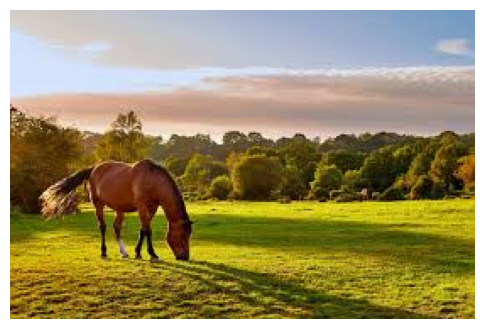

In [ ]:
import matplotlib.pyplot as plt

image_path = "horse.jpeg"
image = Image.open(image_path).convert("RGB")

# Show the image in the notebook
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis("off")  # Hide axes
plt.show()

In [ ]:
from transformers import BlipProcessor, BlipForQuestionAnswering
import torch
from PIL import Image
from difflib import SequenceMatcher

# Load BLIP VQA model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to("cuda")  # Move to GPU if available


# Process and run inference for each question
def compute_similarity(a, b):
    return SequenceMatcher(None, a.lower(), b.lower()).ratio()

# Scoring variables
correct_count = 0
similarity_scores = []

# Process each question
for i, (question, expected_answer) in enumerate(zip(questions, expected_answers)):
    inputs = processor(image, question, return_tensors="pt").to("cuda")

    with torch.no_grad():
        output = model.generate(**inputs, max_length=10)

    predicted_answer = processor.decode(output[0], skip_special_tokens=True)

    # Compute scores
    exact_match = predicted_answer.lower() == expected_answer.lower()
    similarity = compute_similarity(predicted_answer, expected_answer)
    similarity_scores.append(similarity)

    if exact_match:
        correct_count += 1

    # Print result
    print(f"Q{i+1}: {question}")
    print(f"Expected Answer: {expected_answer}")
    print(f"BLIP Answer: {predicted_answer}")
    print(f"Similarity Score: {similarity:.2f} {'✅ Correct!' if exact_match else '❌ Incorrect!'}")
    print("-" * 50)

# Compute final accuracy
accuracy = (correct_count / len(questions)) * 100
average_similarity = sum(similarity_scores) / len(questions)

print(f"Final Accuracy: {accuracy:.2f}%")
print(f"Average Similarity Score: {average_similarity:.2f}")

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Q1: are there horses?
Expected Answer: yes
BLIP Answer: yes
Similarity Score: 1.00 ✅ Correct!
--------------------------------------------------
Q2: what animals are in the picture?
Expected Answer: horses
BLIP Answer: horse
Similarity Score: 0.91 ❌ Incorrect!
--------------------------------------------------
Q3: is there grass?
Expected Answer: yes
BLIP Answer: yes
Similarity Score: 1.00 ✅ Correct!
--------------------------------------------------
Q4: what is the horses eating?
Expected Answer: grass
BLIP Answer: grass
Similarity Score: 1.00 ✅ Correct!
--------------------------------------------------
Final Accuracy: 75.00%
Average Similarity Score: 0.98
